#### Loading and preparing the PCam data for training deep learning models using tensorflow dataset (tfds)

Loading the required libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import CSVLogger, Callback
import keras.backend as K
import os

Defining a function that splits images and labels and one-hot-encodes the labels

In [2]:
# Get current working directory
cwd = pathlib.Path.cwd()

In [3]:
# Load data from cwd
ds1, ds2, ds3 = tfds.load('patch_camelyon', split=['train[:30%]', 'test[:7%]', 'validation[:7%]'], #-----------------------------
                                data_dir=cwd, 
                                download=False, 
                                shuffle_files=True)

In [4]:
#num_classes = 2  # Assuming you have two classes: cancer and non-cancer

## Function to count the labels
#def count_labels(dataset):
    #counts = [0] * num_classes
    #for _, label in dataset:  # Adjusted to unpack the correct structure
    #    label = label.numpy()  # Convert the label tensor to a numpy array
    #    counts[np.argmax(label)] += 1
    #return counts

# Since the dataset is batched, unbatch it first to count each instance separately
#autoencoder_train_dataset_unbatched = autoencoder_train_dataset.unbatch()

# Count labels in the unbatched training dataset
#label_counts = count_labels(autoencoder_train_dataset_unbatched)

# Plotting
#colors = ["skyblue", "salmon"]  # Assign colors for each class
#plt.bar(range(num_classes), label_counts, color=colors)
#plt.xlabel('Class')
#plt.ylabel


In [5]:
batch_size = 32

# For the autoencoder
def preprocess_for_autoencoder(sample):
    image = tf.image.convert_image_dtype(sample['image'], tf.float32)
    return image, image  # return image as both input and target

autoencoder_train_dataset = ds1.map(preprocess_for_autoencoder).batch(batch_size)
autoencoder_validation_dataset = ds2.map(preprocess_for_autoencoder).batch(batch_size)
autoencoder_test_dataset = ds3.map(preprocess_for_autoencoder).batch(batch_size)

Next, getting ready for training by splitting it into batches.

## 1.2
Build and train autoencoders that efficiently compress the 96x96pxs color images (as a minimum train one AE model and one VAE model)

In [6]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(96, 96, 3)),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', strides=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', strides=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    # Add another convolutional layer with stride of 2 to reduce spatial dimensions further to 24x24
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', strides=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
], name='encoder')



print(encoder.summary())

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 16)       64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 48, 48, 32)        0   

In [7]:
decoder = tf.keras.models.Sequential([
    # Start with an input layer that accepts the encoded flat vector or shape (24, 24, 64)
    tf.keras.layers.InputLayer(input_shape=(24, 24, 64)),
    
    # Upsample the image back to (48, 48, 32)
    tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    # Upsample the image back to (96, 96, 16)
    tf.keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    # Final convolution to get back to the original size and channel depth
    tf.keras.layers.Conv2D(3, kernel_size=(3, 3), padding='same', activation='sigmoid')  # Use 'sigmoid' if the data is normalized between 0 and 1
], name='decoder')


print(decoder.summary())

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 48, 48, 32)       18464     
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 48, 48, 32)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 96, 96, 16)       4624      
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 96, 96, 16)       64        
 hNormalization)                                           

In [8]:
#from tensorflow.keras.utils import plot_model

# Assuming 'encoder' and 'decoder' are your model instances
#plot_model(encoder, to_file='encoder_architecture.png', show_shapes=True, show_layer_names=True)
#plot_model(decoder, to_file='decoder_architecture.png', show_shapes=True, show_layer_names=True)


### Autoencoder

In [9]:
autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')

# Your learning rate schedule
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

# Create an Adam optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the autoencoder with the custom optimizer
autoencoder.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])


In [10]:
# Fit the model on the data and the labels
epochs_autoencoder = 55

class SaveBestEncoder(Callback):
    def __init__(self, encoder, filepath, monitor='val_loss', mode='min'):
        super(SaveBestEncoder, self).__init__()
        self.encoder = encoder
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best = float('inf') if mode == 'min' else -float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_val = logs.get(self.monitor)
        if self.mode == 'min' and current_val < self.best:
            self.best = current_val
            self.encoder.save(self.filepath)
        elif self.mode == 'max' and current_val > self.best:
            self.best = current_val
            self.encoder.save(self.filepath)

# Usage in training
save_best_encoder_callback = SaveBestEncoder(encoder, 'ae_low_best_encoder.h5')
callback_model=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1) # early stopping


# Create CSVLogger callback to save history
csv_filepath = 'ae_low_training_log.csv'
csv_logger = CSVLogger(csv_filepath, append=True)

history = autoencoder.fit(
    autoencoder_train_dataset,
    validation_data=autoencoder_validation_dataset,
    verbose=1,
    epochs=epochs_autoencoder,
    callbacks=[save_best_encoder_callback, callback_model, csv_logger]  # Add custom callback here
)


Epoch 1/55
2458/2458 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.6514WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 292s 118ms/step - loss: 0.0143 - accuracy: 0.6514 - val_loss: 0.0044 - val_accuracy: 0.7570
Epoch 2/55
2458/2458 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.7813WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 291s 118ms/step - loss: 0.0033 - accuracy: 0.7813 - val_loss: 0.0020 - val_accuracy: 0.7968
Epoch 3/55
2458/2458 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.8131WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 288s 117ms/step - loss: 0.0021 - accuracy: 0.8131 - val_loss: 0.0014 - val_accuracy: 0.8244
Epoch 4/55
2458/2458 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.8252WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 285s 116ms/step - loss: 0.0017 - accuracy: 0.8252 - val_loss: 0.0011 - val_accuracy: 0.8308
Epoch 5/55
2458/2458 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.8329WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 286s 116ms/step - loss: 0.0014 - accuracy: 0.8329 - val_loss: 0.0010 - val_accuracy: 0.8290
Epoch 6/55
2458/2458 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.8387WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 286s 116ms/step - loss: 0.0013 - accuracy: 0.8387 - val_loss: 8.8256e-04 - val_accuracy: 0.8470
Epoch 7/55
2458/2458 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.8430WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 286s 116ms/step - loss: 0.0011 - accuracy: 0.8430 - val_loss: 7.9485e-04 - val_accuracy: 0.8574
Epoch 8/55
2458/2458 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 0.8487WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 288s 117ms/step - loss: 0.0010 - accuracy: 0.8487 - val_loss: 7.1455e-04 - val_accuracy: 0.8608
Epoch 9/55
2458/2458 [==============================] - 288s 117ms/step - loss: 9.8048e-04 - accuracy: 0.8518 - val_loss: 7.6077e-04 - val_accuracy: 0.8739
Epoch 10/55
2458/2458 [==============================] - ETA: 0s - loss: 9.4092e-04 - accuracy: 0.8552WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 289s 118ms/step - loss: 9.4092e-04 - accuracy: 0.8552 - val_loss: 7.0991e-04 - val_accuracy: 0.8689
Epoch 11/55
2458/2458 [==============================] - ETA: 0s - loss: 8.8453e-04 - accuracy: 0.8577WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 288s 117ms/step - loss: 8.8453e-04 - accuracy: 0.8577 - val_loss: 6.6385e-04 - val_accuracy: 0.8850
Epoch 12/55
2458/2458 [==============================] - ETA: 0s - loss: 8.4542e-04 - accuracy: 0.8604WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 288s 117ms/step - loss: 8.4542e-04 - accuracy: 0.8604 - val_loss: 6.1164e-04 - val_accuracy: 0.8702
Epoch 13/55
2458/2458 [==============================] - 288s 117ms/step - loss: 8.1645e-04 - accuracy: 0.8623 - val_loss: 6.5803e-04 - val_accuracy: 0.8676
Epoch 14/55
2458/2458 [==============================] - ETA: 0s - loss: 7.7180e-04 - accuracy: 0.8640WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 288s 117ms/step - loss: 7.7180e-04 - accuracy: 0.8640 - val_loss: 5.1577e-04 - val_accuracy: 0.8891
Epoch 15/55
2458/2458 [==============================] - 285s 116ms/step - loss: 7.3807e-04 - accuracy: 0.8654 - val_loss: 5.6861e-04 - val_accuracy: 0.8759
Epoch 16/55
2458/2458 [==============================] - 287s 117ms/step - loss: 7.1514e-04 - accuracy: 0.8665 - val_loss: 6.2123e-04 - val_accuracy: 0.8818
Epoch 17/55
2458/2458 [==============================] - ETA: 0s - loss: 6.9394e-04 - accuracy: 0.8684WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 287s 117ms/step - loss: 6.9394e-04 - accuracy: 0.8684 - val_loss: 4.5143e-04 - val_accuracy: 0.8925
Epoch 18/55
2458/2458 [==============================] - 286s 116ms/step - loss: 6.6805e-04 - accuracy: 0.8690 - val_loss: 6.0239e-04 - val_accuracy: 0.8687
Epoch 19/55
2458/2458 [==============================] - 286s 116ms/step - loss: 6.4419e-04 - accuracy: 0.8713 - val_loss: 5.3788e-04 - val_accuracy: 0.8922
Epoch 20/55
2458/2458 [==============================] - ETA: 0s - loss: 6.3620e-04 - accuracy: 0.8716WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 283s 115ms/step - loss: 6.3620e-04 - accuracy: 0.8716 - val_loss: 4.3306e-04 - val_accuracy: 0.9074
Epoch 21/55
2458/2458 [==============================] - ETA: 0s - loss: 6.1189e-04 - accuracy: 0.8733WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 284s 115ms/step - loss: 6.1189e-04 - accuracy: 0.8733 - val_loss: 4.2560e-04 - val_accuracy: 0.8897
Epoch 22/55
2458/2458 [==============================] - 283s 115ms/step - loss: 5.7537e-04 - accuracy: 0.8746 - val_loss: 4.2686e-04 - val_accuracy: 0.8973
Epoch 23/55
2458/2458 [==============================] - ETA: 0s - loss: 5.7260e-04 - accuracy: 0.8744WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 285s 116ms/step - loss: 5.7260e-04 - accuracy: 0.8744 - val_loss: 3.9401e-04 - val_accuracy: 0.9014
Epoch 24/55
2458/2458 [==============================] - 285s 116ms/step - loss: 5.4727e-04 - accuracy: 0.8750 - val_loss: 4.7034e-04 - val_accuracy: 0.9040
Epoch 25/55
2458/2458 [==============================] - 284s 115ms/step - loss: 5.3634e-04 - accuracy: 0.8750 - val_loss: 4.5897e-04 - val_accuracy: 0.8847
Epoch 26/55
2458/2458 [==============================] - 285s 116ms/step - loss: 5.1523e-04 - accuracy: 0.8761 - val_loss: 3.9811e-04 - val_accuracy: 0.9075
Epoch 27/55
2458/2458 [==============================] - 284s 116ms/step - loss: 5.1130e-04 - accuracy: 0.8764 - val_loss: 9.0471e-04 - val_accuracy: 0.8394
Epoch 28/55
2458/2458 [==============================] - 284s 116ms/step - loss: 5.0044e-04 - accuracy: 0.8770 - val_loss: 4.9442e-04 - val_accuracy: 0.8689
Epoch 29/55
2458/2458 [==============================] - 286s 117ms/st

2458/2458 [==============================] - 287s 117ms/step - loss: 4.7684e-04 - accuracy: 0.8785 - val_loss: 3.7267e-04 - val_accuracy: 0.9071
Epoch 31/55
2458/2458 [==============================] - ETA: 0s - loss: 4.6910e-04 - accuracy: 0.8795WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 284s 116ms/step - loss: 4.6910e-04 - accuracy: 0.8795 - val_loss: 3.2031e-04 - val_accuracy: 0.8967
Epoch 32/55
2458/2458 [==============================] - 284s 116ms/step - loss: 4.5690e-04 - accuracy: 0.8793 - val_loss: 3.7940e-04 - val_accuracy: 0.8866
Epoch 33/55
2458/2458 [==============================] - 284s 115ms/step - loss: 4.4777e-04 - accuracy: 0.8801 - val_loss: 3.5145e-04 - val_accuracy: 0.8914
Epoch 34/55
2458/2458 [==============================] - 283s 115ms/step - loss: 4.4080e-04 - accuracy: 0.8810 - val_loss: 3.4386e-04 - val_accuracy: 0.8999
Epoch 35/55
2458/2458 [==============================] - ETA: 0s - loss: 4.2811e-04 - accuracy: 0.8823WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 285s 116ms/step - loss: 4.2811e-04 - accuracy: 0.8823 - val_loss: 3.1607e-04 - val_accuracy: 0.8953
Epoch 36/55
2458/2458 [==============================] - 285s 116ms/step - loss: 4.1915e-04 - accuracy: 0.8835 - val_loss: 3.2707e-04 - val_accuracy: 0.9029
Epoch 37/55
2458/2458 [==============================] - 286s 116ms/step - loss: 4.1714e-04 - accuracy: 0.8839 - val_loss: 3.3119e-04 - val_accuracy: 0.9058
Epoch 38/55
2458/2458 [==============================] - 285s 116ms/step - loss: 4.0114e-04 - accuracy: 0.8848 - val_loss: 3.5490e-04 - val_accuracy: 0.9009
Epoch 39/55
2458/2458 [==============================] - ETA: 0s - loss: 3.9843e-04 - accuracy: 0.8859WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 285s 116ms/step - loss: 3.9843e-04 - accuracy: 0.8859 - val_loss: 3.0988e-04 - val_accuracy: 0.9092
Epoch 40/55
2458/2458 [==============================] - 285s 116ms/step - loss: 3.9363e-04 - accuracy: 0.8859 - val_loss: 3.2932e-04 - val_accuracy: 0.9099
Epoch 41/55
2458/2458 [==============================] - ETA: 0s - loss: 3.8904e-04 - accuracy: 0.8872WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 286s 116ms/step - loss: 3.8904e-04 - accuracy: 0.8872 - val_loss: 2.8885e-04 - val_accuracy: 0.9069
Epoch 42/55
2458/2458 [==============================] - 286s 116ms/step - loss: 3.8402e-04 - accuracy: 0.8879 - val_loss: 3.2348e-04 - val_accuracy: 0.9206
Epoch 43/55
2458/2458 [==============================] - 286s 116ms/step - loss: 3.7265e-04 - accuracy: 0.8892 - val_loss: 4.0400e-04 - val_accuracy: 0.8865
Epoch 44/55
2458/2458 [==============================] - 287s 117ms/step - loss: 3.7344e-04 - accuracy: 0.8891 - val_loss: 6.8538e-04 - val_accuracy: 0.8375
Epoch 45/55
2458/2458 [==============================] - ETA: 0s - loss: 3.6246e-04 - accuracy: 0.8902WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 287s 117ms/step - loss: 3.6246e-04 - accuracy: 0.8902 - val_loss: 2.7872e-04 - val_accuracy: 0.9015
Epoch 46/55
2458/2458 [==============================] - 286s 116ms/step - loss: 3.6392e-04 - accuracy: 0.8902 - val_loss: 3.5807e-04 - val_accuracy: 0.9224
Epoch 47/55
2458/2458 [==============================] - 285s 116ms/step - loss: 3.5038e-04 - accuracy: 0.8915 - val_loss: 2.7986e-04 - val_accuracy: 0.8954
Epoch 48/55
2458/2458 [==============================] - ETA: 0s - loss: 3.5116e-04 - accuracy: 0.8917WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 286s 116ms/step - loss: 3.5116e-04 - accuracy: 0.8917 - val_loss: 2.7035e-04 - val_accuracy: 0.9141
Epoch 49/55
2458/2458 [==============================] - 285s 116ms/step - loss: 3.4765e-04 - accuracy: 0.8922 - val_loss: 3.1725e-04 - val_accuracy: 0.9115
Epoch 50/55
2458/2458 [==============================] - ETA: 0s - loss: 3.3802e-04 - accuracy: 0.8937WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 284s 116ms/step - loss: 3.3802e-04 - accuracy: 0.8937 - val_loss: 2.5020e-04 - val_accuracy: 0.9110
Epoch 51/55
2458/2458 [==============================] - 286s 116ms/step - loss: 3.4159e-04 - accuracy: 0.8936 - val_loss: 2.7974e-04 - val_accuracy: 0.9032
Epoch 52/55
2458/2458 [==============================] - 285s 116ms/step - loss: 3.3343e-04 - accuracy: 0.8938 - val_loss: 3.5407e-04 - val_accuracy: 0.9122
Epoch 53/55
2458/2458 [==============================] - 287s 117ms/step - loss: 3.2757e-04 - accuracy: 0.8943 - val_loss: 3.3693e-04 - val_accuracy: 0.9184
Epoch 54/55
2458/2458 [==============================] - ETA: 0s - loss: 3.2460e-04 - accuracy: 0.8954WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 286s 116ms/step - loss: 3.2460e-04 - accuracy: 0.8954 - val_loss: 2.4840e-04 - val_accuracy: 0.9062
Epoch 55/55
2458/2458 [==============================] - 284s 116ms/step - loss: 3.1955e-04 - accuracy: 0.8951 - val_loss: 2.9881e-04 - val_accuracy: 0.9265


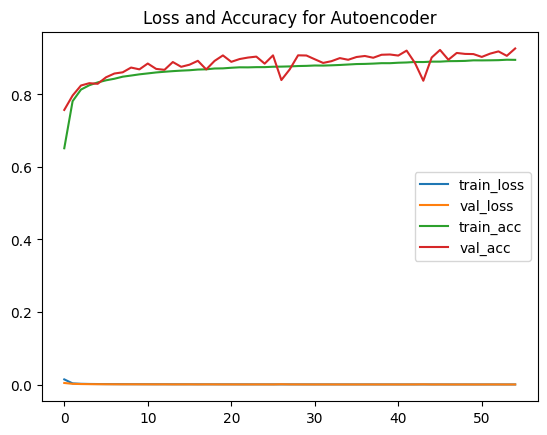

In [11]:
import matplotlib.pyplot as plt

# Plot Loss and accuracy
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Loss and Accuracy for Autoencoder')
plt.legend()
plt.savefig('loss_and_accuracy_for_low_ae.png')  # Save the figure before plt.show()
plt.show()
plt.close()


In [12]:
# save the encoder only
encoder.save('low_ae_encoder.h5')

### Visual inspection of the reconsructed images vs the real ones

1/1 [==============================] - 0s 174ms/step


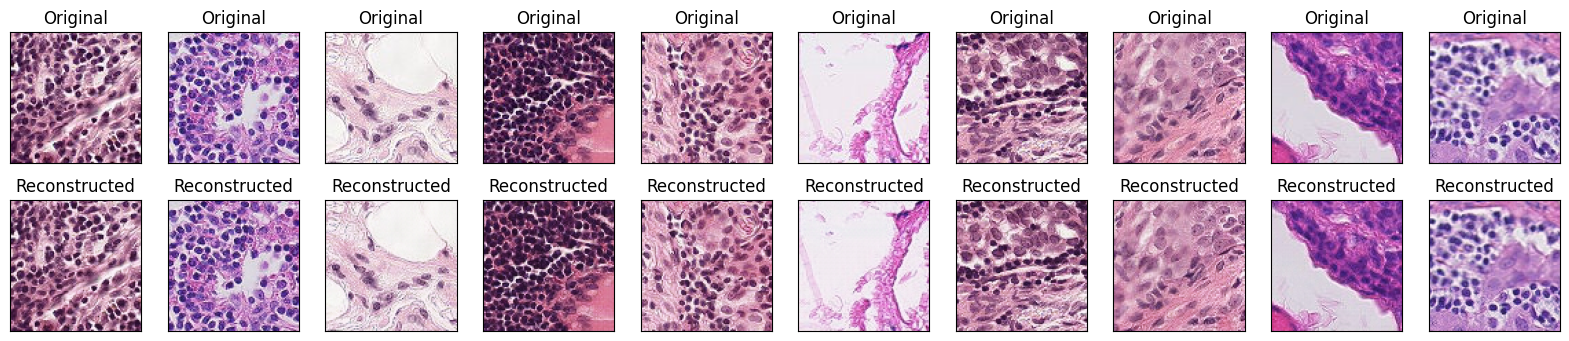

In [13]:
# Take one batch of images from the dataset
for original_images, _ in autoencoder_train_dataset.take(1):
    break

# Get reconstructed images from the autoencoder
reconstructed_images = autoencoder.predict(original_images)

# Define how many images you want to display
n = 10  # for example, display 10 images

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_images[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig("low_images_compare.png")
plt.show()
plt.close()

### Compress the data using the trained encoder

In [4]:
# load the model from file
encoder = tf.keras.models.load_model('low_ae_encoder.h5')

# Print the encoder summary
print(encoder.summary())


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 16)       64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 48, 48, 32)        0   

In [ ]:
# preprocess for cnn

In [5]:
num_classes = 2
batch_size = 32

def preprocess_encode_and_label(sample):
    # Preprocess the image
    image = tf.image.convert_image_dtype(sample['image'], tf.float32)
    image = tf.image.resize(image, [96, 96])

    # Add a batch dimension
    image = tf.expand_dims(image, 0)

    # Encode the image using the trained encoder
    encoded_image = encoder(image, training=False)

    # Remove the batch dimension
    encoded_image = tf.squeeze(encoded_image, 0)

    # One-hot encode the label
    label = tf.one_hot(sample['label'], num_classes, dtype=tf.float32)

    return encoded_image, label

# Apply the function to your datasets
encoded_classifier_train_dataset = ds1.map(preprocess_encode_and_label).batch(batch_size)
encoded_classifier_val_dataset = ds2.map(preprocess_encode_and_label).batch(batch_size)
encoded_classifier_test_dataset = ds3.map(preprocess_encode_and_label).batch(batch_size)


In [17]:
# Print the structure and shapes of the dataset elements
print('Element structure:', encoded_classifier_train_dataset.element_spec)

# To inspect the shape of the first batch of data
for encoded_images, labels in encoded_classifier_train_dataset.take(1):
    print('Shape of encoded images:', encoded_images.shape)
    print('Shape of labels:', labels.shape)


Element structure: (TensorSpec(shape=(None, 24, 24, 64), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))
Shape of encoded images: (32, 24, 24, 64)
Shape of labels: (32, 2)


In [ ]:
#So, when working within a tf.data.Dataset pipeline, it's more efficient and appropriate to call the model directly, 
#as in encoder(image, training=False), which is graph-compatible and optimized for performance within the TensorFlow ecosystem.

### CNN

In [6]:
encoded_shape = (24,24,64) # shape of the output of the encoder

# Create a new CNN model
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=encoded_shape),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callback_model=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1) # early stopping

# Print the summary of the model
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 64)                294976    
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 313,570
Trainable params: 313,570
Non-trainable params: 0
__________________________________________________

In [7]:
# Train the model
epochs_cnn = 55 #---------------------------------------------

history = cnn_model.fit(encoded_classifier_train_dataset, 
              validation_data=encoded_classifier_val_dataset,
              callbacks=[callback_model],
              epochs=epochs_cnn)

Epoch 1/55
2458/2458 [==============================] - 344s 140ms/step - loss: 0.4556 - accuracy: 0.7884 - val_loss: 0.5311 - val_accuracy: 0.7554
Epoch 2/55
2458/2458 [==============================] - 348s 141ms/step - loss: 0.3914 - accuracy: 0.8291 - val_loss: 0.5556 - val_accuracy: 0.7493
Epoch 3/55
2458/2458 [==============================] - 357s 145ms/step - loss: 0.3647 - accuracy: 0.8439 - val_loss: 0.5056 - val_accuracy: 0.7650
Epoch 4/55
2458/2458 [==============================] - 348s 142ms/step - loss: 0.3437 - accuracy: 0.8535 - val_loss: 0.5934 - val_accuracy: 0.7306
Epoch 5/55
2458/2458 [==============================] - 351s 143ms/step - loss: 0.3245 - accuracy: 0.8635 - val_loss: 0.4984 - val_accuracy: 0.7685
Epoch 6/55
2458/2458 [==============================] - 342s 139ms/step - loss: 0.3080 - accuracy: 0.8714 - val_loss: 0.6615 - val_accuracy: 0.7293
Epoch 7/55
2458/2458 [==============================] - 330s 134ms/step - loss: 0.2905 - accuracy: 0.8804 - val_

In [8]:
cnn_model.save('low_ae_model.h5')

# Convert the history.history dict to a pandas DataFrame
hist_df = pd.DataFrame(history.history)

# Save to csv
hist_df.to_csv('low_history.csv')


In [ ]:
#cnn_model = tf.keras.models.load_model('my_ae_model.h5')

In [9]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 64)                294976    
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 313,570
Trainable params: 313,570
Non-trainable params: 0
__________________________________________________

In [10]:
predictions = cnn_model.predict(encoded_classifier_test_dataset)

predictions = np.argmax(predictions, axis=1)

predictions_pd = pd.DataFrame({
    'Id': list(range(len(predictions))),
    'Predicted': predictions.reshape(-1,),
})

predictions_pd.to_csv('low_ae_predictions.csv', index=False)

72/72 [==============================] - 10s 139ms/step


In [11]:
# Assuming the encoded_test_dataset is already batched and prefetched
true_labels = []
for images, labels in encoded_classifier_test_dataset.unbatch().take(len(predictions)):
    true_labels.append(labels.numpy())

# Convert the true labels to a numpy array
true_labels = np.array(true_labels)

# If true_labels is one-hot encoded, convert it to class indices
true_labels = np.argmax(true_labels, axis=1)

# Generate predictions
predictions = cnn_model.predict(encoded_classifier_test_dataset)

# If predictions are probabilities, use argmax to get predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the accuracy
accuracy = np.mean(predicted_labels == true_labels)
my_string = f"Accuracy: {accuracy * 100:.2f}%"
print(my_string)


72/72 [==============================] - 10s 131ms/step
Accuracy: 82.08%


In [12]:
# Open the file in write mode ('w') and write the string to it
with open("low_ae_accuracy.csv", 'w') as file:
    file.write(my_string)